# Analysis of DNA-MERFISH for CTP11,12,13

by Pu Zheng

2022.07.07

analysis for dataset:

dna_data_folder = r'\\10.245.74.158\Chromatin_NAS_4\20220316-P_brain_CTP11-12-13_from_0304'

rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors'

save_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304'

In [2]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

42836


## 0.1 Folders

In [3]:
save_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304'
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

analysis_folder = os.path.join(save_folder, 'Analysis_0706')

segmentation_folder = os.path.join(analysis_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(analysis_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")

168 fovs detected
Creating segmentation_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Segmentation
Creating cand_spot_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\CandSpots
Creating decoder_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Decoder


In [4]:
pixel_sizes = np.array([250,108,108])
single_im_size = np.array([50,2048,2048])

# 1. Translate segmentation

## 1.1 load rotation

In [6]:
# generate alignment
dna_data_folder = r'\\10.245.74.158\Chromatin_NAS_4\20220316-P_brain_CTP11-12-13_from_0304'
rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors'

rna_alignment_file = os.path.join(rna_data_folder, 'Alignment', '10x_positions_before.txt')
dna_alignment_file = os.path.join(dna_data_folder, 'Alignment', '10x_positions_after.txt')
print(rna_alignment_file, '\n', dna_alignment_file)
print(os.path.exists(rna_alignment_file), os.path.exists(dna_alignment_file))
R, t = ia.correction_tools.alignment.align_manual_points(rna_alignment_file, dna_alignment_file,
                                                         save_folder=save_folder)

\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Alignment\10x_positions_before.txt 
 \\10.245.74.158\Chromatin_NAS_4\20220316-P_brain_CTP11-12-13_from_0304\Alignment\10x_positions_after.txt
True True
- Manually picked points aligned, rotation:
[[ 0.99997433 -0.00716481]
 [ 0.00716481  0.99997433]],
 translation:[-238.54348979 -722.53301093]
-- rotation matrix saved to file:\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\rotation
-- translation matrix saved to file:\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\translation


# 1.2 save DAPI image for RNA

In [9]:
# MERFISH segmentation info
merfish_segmentation_folder = r'\\10.245.74.158\Chromatin_NAS_8\MERFISH\v2\20220304-storm6_M1\CellPoseSegment\features'
merfish_dapi_folder = os.path.join(analysis_folder, 'Merfish_DAPI')
if not os.path.exists(merfish_dapi_folder):
    print(merfish_dapi_folder)
    os.makedirs(merfish_dapi_folder)

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Merfish_DAPI


In [7]:
from tqdm import tqdm
rna_fds, rna_fovs = ia.io_tools.data.get_folders(rna_data_folder)
ref_fd = rna_fds[0]

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 11
- Number of field of views: 168


In [16]:
reload(ia.classes.preprocess)

<module 'ImageAnalysis3.classes.preprocess' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\preprocess.py'>

In [17]:
overwrite_dapi = True
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

for _fov_id in tqdm(save_fov_ids):
    _dapi_savefile = os.path.join(merfish_dapi_folder, rna_fovs[_fov_id].replace('.dax', '_Dapi.npy'))
    if overwrite_dapi or not os.path.exists(_dapi_savefile):
        # load 
        _dapi_filename = os.path.join(ref_fd, rna_fovs[_fov_id])
        _ref_cls = ia.classes.preprocess.DaxProcesser(_dapi_filename, 
                                                      CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
        _ref_cls._load_image(sel_channels=[405])
        _ref_cls._corr_illumination(correction_channels=[405])
        _dapi_im = _ref_cls.im_405
        # save
        np.save(_dapi_savefile.split('.npy')[0], _dapi_im)

  0%|                                                                                          | 0/168 [00:00<?, ?it/s]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_000.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.642s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.417s.
- Finished illumination correction in 7.604s.


  1%|▍                                                                                 | 1/168 [00:14<40:48, 14.66s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_001.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.416s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.236s.
- Finished illumination correction in 7.320s.


  1%|▉                                                                                 | 2/168 [00:29<40:28, 14.63s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_002.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.692s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.344s.
- Finished illumination correction in 7.445s.


  2%|█▍                                                                                | 3/168 [00:44<40:38, 14.78s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_003.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.761s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.525s.
- Finished illumination correction in 7.618s.


  2%|█▉                                                                                | 4/168 [00:59<40:55, 14.97s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_004.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.683s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.810s.
- Finished illumination correction in 7.830s.


  3%|██▍                                                                               | 5/168 [01:15<41:11, 15.17s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_005.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.629s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.870s.
- Finished illumination correction in 7.972s.


  4%|██▉                                                                               | 6/168 [01:31<42:17, 15.66s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_006.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.737s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.730s.
- Finished illumination correction in 7.837s.


  4%|███▍                                                                              | 7/168 [01:47<41:52, 15.61s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_007.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.431s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.721s.
- Finished illumination correction in 7.807s.


  5%|███▉                                                                              | 8/168 [02:03<42:02, 15.76s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_008.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.635s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.733s.
- Finished illumination correction in 7.828s.


  5%|████▍                                                                             | 9/168 [02:18<41:30, 15.66s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_009.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.657s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.893s.
- Finished illumination correction in 7.979s.


  6%|████▊                                                                            | 10/168 [02:34<41:15, 15.67s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_010.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.639s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.995s.
- Finished illumination correction in 8.081s.


  7%|█████▎                                                                           | 11/168 [02:49<40:58, 15.66s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_011.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.014s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.767s.
- Finished illumination correction in 7.895s.


  7%|█████▊                                                                           | 12/168 [03:05<40:54, 15.74s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_012.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.761s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.246s.
- Finished illumination correction in 8.350s.


  8%|██████▎                                                                          | 13/168 [03:21<40:51, 15.82s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_013.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.038s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.841s.
- Finished illumination correction in 7.936s.


  8%|██████▊                                                                          | 14/168 [03:37<40:42, 15.86s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_014.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.871s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.000s.
- Finished illumination correction in 8.096s.


  9%|███████▏                                                                         | 15/168 [03:53<40:32, 15.90s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_015.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.628s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.166s.
- Finished illumination correction in 8.265s.


 10%|███████▋                                                                         | 16/168 [04:10<41:05, 16.22s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_016.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.189s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.378s.
- Finished illumination correction in 8.498s.


 10%|████████▏                                                                        | 17/168 [04:27<41:13, 16.38s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_017.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.908s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.204s.
- Finished illumination correction in 8.301s.


 11%|████████▋                                                                        | 18/168 [04:43<40:51, 16.34s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_018.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.747s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.164s.
- Finished illumination correction in 8.259s.


 11%|█████████▏                                                                       | 19/168 [05:00<41:01, 16.52s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_019.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.291s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.938s.
- Finished illumination correction in 8.034s.


 12%|█████████▋                                                                       | 20/168 [05:16<39:51, 16.16s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_020.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.778s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.079s.
- Finished illumination correction in 8.167s.


 12%|██████████▏                                                                      | 21/168 [05:32<39:27, 16.10s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_021.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.167s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.091s.
- Finished illumination correction in 8.228s.


 13%|██████████▌                                                                      | 22/168 [05:48<39:18, 16.15s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_022.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.535s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.965s.
- Finished illumination correction in 8.065s.


 14%|███████████                                                                      | 23/168 [06:03<38:39, 16.00s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_023.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.842s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.057s.
- Finished illumination correction in 8.148s.


 14%|███████████▌                                                                     | 24/168 [06:19<38:21, 15.98s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_024.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.875s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.121s.
- Finished illumination correction in 8.214s.


 15%|████████████                                                                     | 25/168 [06:36<38:12, 16.03s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_025.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.308s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.399s.
- Finished illumination correction in 8.494s.


 15%|████████████▌                                                                    | 26/168 [06:51<37:49, 15.99s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_026.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.466s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.912s.
- Finished illumination correction in 8.044s.


 16%|█████████████                                                                    | 27/168 [07:08<37:53, 16.12s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_027.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.618s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.602s.
- Finished illumination correction in 8.699s.


 17%|█████████████▌                                                                   | 28/168 [07:25<38:25, 16.47s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_028.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.844s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.123s.
- Finished illumination correction in 8.215s.


 17%|█████████████▉                                                                   | 29/168 [07:41<37:49, 16.33s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_029.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.319s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.846s.
- Finished illumination correction in 7.934s.


 18%|██████████████▍                                                                  | 30/168 [07:57<37:28, 16.30s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_030.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.255s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.966s.
- Finished illumination correction in 8.068s.


 18%|██████████████▉                                                                  | 31/168 [08:14<37:10, 16.28s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_031.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.852s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.824s.
- Finished illumination correction in 7.940s.


 19%|███████████████▍                                                                 | 32/168 [08:29<36:33, 16.13s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_032.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.775s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.950s.
- Finished illumination correction in 8.037s.


 20%|███████████████▉                                                                 | 33/168 [08:46<36:41, 16.31s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_033.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.367s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.010s.
- Finished illumination correction in 8.104s.


 20%|████████████████▍                                                                | 34/168 [09:03<36:32, 16.36s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_034.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.989s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.986s.
- Finished illumination correction in 8.008s.


 21%|████████████████▉                                                                | 35/168 [09:18<35:28, 16.00s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_035.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.681s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.905s.
- Finished illumination correction in 7.998s.


 21%|█████████████████▎                                                               | 36/168 [09:33<34:55, 15.88s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_036.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.849s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.245s.
- Finished illumination correction in 8.372s.


 22%|█████████████████▊                                                               | 37/168 [09:50<34:51, 15.96s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_037.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.845s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.232s.
- Finished illumination correction in 8.326s.


 23%|██████████████████▎                                                              | 38/168 [10:06<34:44, 16.03s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_038.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.179s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.307s.
- Finished illumination correction in 8.405s.


 23%|██████████████████▊                                                              | 39/168 [10:21<34:09, 15.89s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_039.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.841s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.823s.
- Finished illumination correction in 7.915s.


 24%|███████████████████▎                                                             | 40/168 [10:37<33:43, 15.81s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_040.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.401s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.904s.
- Finished illumination correction in 7.997s.


 24%|███████████████████▊                                                             | 41/168 [10:52<33:10, 15.67s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_041.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.687s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.021s.
- Finished illumination correction in 8.153s.


 25%|████████████████████▎                                                            | 42/168 [11:08<33:02, 15.74s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_042.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.006s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.836s.
- Finished illumination correction in 7.935s.


 26%|████████████████████▋                                                            | 43/168 [11:24<32:55, 15.80s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_043.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.828s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.915s.
- Finished illumination correction in 8.012s.


 26%|█████████████████████▏                                                           | 44/168 [11:39<32:01, 15.50s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_044.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.659s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.913s.
- Finished illumination correction in 8.008s.


 27%|█████████████████████▋                                                           | 45/168 [11:55<31:54, 15.56s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_045.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.328s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.819s.
- Finished illumination correction in 7.922s.


 27%|██████████████████████▏                                                          | 46/168 [12:11<32:01, 15.75s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_046.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.634s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.880s.
- Finished illumination correction in 8.010s.


 28%|██████████████████████▋                                                          | 47/168 [12:26<31:43, 15.73s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_047.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.138s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.999s.
- Finished illumination correction in 8.096s.


 29%|███████████████████████▏                                                         | 48/168 [12:42<31:11, 15.59s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_048.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.647s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.863s.
- Finished illumination correction in 7.961s.


 29%|███████████████████████▋                                                         | 49/168 [12:57<30:56, 15.60s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_049.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.856s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.802s.
- Finished illumination correction in 7.913s.


 30%|████████████████████████                                                         | 50/168 [13:14<31:22, 15.96s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_050.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.971s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.790s.
- Finished illumination correction in 7.883s.


 30%|████████████████████████▌                                                        | 51/168 [13:29<30:24, 15.60s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_051.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.058s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.878s.
- Finished illumination correction in 7.999s.


 31%|█████████████████████████                                                        | 52/168 [13:45<30:20, 15.70s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_052.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.858s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.821s.
- Finished illumination correction in 7.916s.


 32%|█████████████████████████▌                                                       | 53/168 [14:00<29:34, 15.43s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_053.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.254s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.941s.
- Finished illumination correction in 8.033s.


 32%|██████████████████████████                                                       | 54/168 [14:15<29:15, 15.40s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_054.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.165s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.112s.
- Finished illumination correction in 8.200s.


 33%|██████████████████████████▌                                                      | 55/168 [14:31<29:35, 15.71s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_055.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.134s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.991s.
- Finished illumination correction in 8.078s.


 33%|███████████████████████████                                                      | 56/168 [14:48<29:35, 15.86s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_056.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.147s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.005s.
- Finished illumination correction in 8.119s.


 34%|███████████████████████████▍                                                     | 57/168 [15:03<28:56, 15.65s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_057.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.211s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.972s.
- Finished illumination correction in 8.069s.


 35%|███████████████████████████▉                                                     | 58/168 [15:18<28:27, 15.52s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_058.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.377s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.911s.
- Finished illumination correction in 8.010s.


 35%|████████████████████████████▍                                                    | 59/168 [15:33<28:03, 15.44s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_059.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.060s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.966s.
- Finished illumination correction in 8.057s.


 36%|████████████████████████████▉                                                    | 60/168 [15:48<27:34, 15.32s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_060.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.496s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.777s.
- Finished illumination correction in 7.886s.


 36%|█████████████████████████████▍                                                   | 61/168 [16:04<27:17, 15.30s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_061.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.887s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.952s.
- Finished illumination correction in 8.085s.


 37%|█████████████████████████████▉                                                   | 62/168 [16:19<27:21, 15.49s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_062.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.098s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.979s.
- Finished illumination correction in 8.071s.


 38%|██████████████████████████████▍                                                  | 63/168 [16:35<26:56, 15.39s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_063.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.621s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.043s.
- Finished illumination correction in 8.133s.


 38%|██████████████████████████████▊                                                  | 64/168 [16:50<26:48, 15.47s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_064.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.928s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.905s.
- Finished illumination correction in 8.016s.


 39%|███████████████████████████████▎                                                 | 65/168 [17:07<27:19, 15.92s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_065.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.461s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.798s.
- Finished illumination correction in 7.892s.


 39%|███████████████████████████████▊                                                 | 66/168 [17:23<27:14, 16.02s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_066.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.569s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.838s.
- Finished illumination correction in 7.969s.


 40%|████████████████████████████████▎                                                | 67/168 [17:38<26:16, 15.61s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_067.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.201s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.893s.
- Finished illumination correction in 7.985s.


 40%|████████████████████████████████▊                                                | 68/168 [17:54<26:14, 15.75s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_068.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.252s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.016s.
- Finished illumination correction in 8.110s.


 41%|█████████████████████████████████▎                                               | 69/168 [18:11<26:17, 15.94s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_069.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.110s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.968s.
- Finished illumination correction in 8.072s.


 42%|█████████████████████████████████▊                                               | 70/168 [18:27<26:09, 16.01s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_070.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.174s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.921s.
- Finished illumination correction in 8.014s.


 42%|██████████████████████████████████▏                                              | 71/168 [18:43<25:56, 16.04s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_071.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.270s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.014s.
- Finished illumination correction in 8.138s.


 43%|██████████████████████████████████▋                                              | 72/168 [18:58<25:19, 15.83s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_072.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.900s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.753s.
- Finished illumination correction in 7.841s.


 43%|███████████████████████████████████▏                                             | 73/168 [19:14<24:59, 15.79s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_073.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.864s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.908s.
- Finished illumination correction in 7.996s.


 44%|███████████████████████████████████▋                                             | 74/168 [19:30<24:44, 15.80s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_074.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.590s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.946s.
- Finished illumination correction in 8.032s.


 45%|████████████████████████████████████▏                                            | 75/168 [19:45<24:21, 15.71s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_075.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.903s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.055s.
- Finished illumination correction in 8.166s.


 45%|████████████████████████████████████▋                                            | 76/168 [20:01<24:16, 15.83s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_076.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.769s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.986s.
- Finished illumination correction in 8.081s.


 46%|█████████████████████████████████████▏                                           | 77/168 [20:17<24:00, 15.83s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_077.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.490s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.929s.
- Finished illumination correction in 8.015s.


 46%|█████████████████████████████████████▌                                           | 78/168 [20:33<23:34, 15.71s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_078.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.776s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.805s.
- Finished illumination correction in 7.909s.


 47%|██████████████████████████████████████                                           | 79/168 [20:48<23:13, 15.66s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_079.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.176s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.919s.
- Finished illumination correction in 8.034s.


 48%|██████████████████████████████████████▌                                          | 80/168 [21:04<23:10, 15.80s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_080.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.325s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.998s.
- Finished illumination correction in 8.098s.


 48%|███████████████████████████████████████                                          | 81/168 [21:20<22:42, 15.66s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_081.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.720s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.824s.
- Finished illumination correction in 7.914s.


 49%|███████████████████████████████████████▌                                         | 82/168 [21:35<22:24, 15.63s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_082.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.575s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.041s.
- Finished illumination correction in 8.129s.


 49%|████████████████████████████████████████                                         | 83/168 [21:51<22:13, 15.69s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_083.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.237s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.892s.
- Finished illumination correction in 8.016s.


 50%|████████████████████████████████████████▌                                        | 84/168 [22:06<21:44, 15.53s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_084.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.767s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.598s.
- Finished illumination correction in 7.716s.


 51%|████████████████████████████████████████▉                                        | 85/168 [22:22<21:28, 15.53s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_085.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.951s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.973s.
- Finished illumination correction in 8.057s.


 51%|█████████████████████████████████████████▍                                       | 86/168 [22:37<20:58, 15.34s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_086.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.084s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.028s.
- Finished illumination correction in 8.120s.


 52%|█████████████████████████████████████████▉                                       | 87/168 [22:53<21:03, 15.59s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_087.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.707s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.937s.
- Finished illumination correction in 8.053s.


 52%|██████████████████████████████████████████▍                                      | 88/168 [23:08<20:48, 15.61s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_088.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.098s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.753s.
- Finished illumination correction in 7.856s.


 53%|██████████████████████████████████████████▉                                      | 89/168 [23:24<20:37, 15.67s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_089.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.965s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.019s.
- Finished illumination correction in 8.038s.


 54%|███████████████████████████████████████████▍                                     | 90/168 [23:39<20:04, 15.45s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_090.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.036s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.990s.
- Finished illumination correction in 8.081s.


 54%|███████████████████████████████████████████▉                                     | 91/168 [23:54<19:39, 15.32s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_091.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.691s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.885s.
- Finished illumination correction in 7.990s.


 55%|████████████████████████████████████████████▎                                    | 92/168 [24:10<19:32, 15.42s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_092.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.729s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.016s.
- Finished illumination correction in 8.112s.


 55%|████████████████████████████████████████████▊                                    | 93/168 [24:26<19:26, 15.56s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_093.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.106s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.175s.
- Finished illumination correction in 8.267s.


 56%|█████████████████████████████████████████████▎                                   | 94/168 [24:42<19:30, 15.82s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_094.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.934s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.987s.
- Finished illumination correction in 8.081s.


 57%|█████████████████████████████████████████████▊                                   | 95/168 [24:58<19:17, 15.86s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_095.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.478s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.003s.
- Finished illumination correction in 8.121s.


 57%|██████████████████████████████████████████████▎                                  | 96/168 [25:15<19:18, 16.09s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_096.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.007s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.856s.
- Finished illumination correction in 7.970s.


 58%|██████████████████████████████████████████████▊                                  | 97/168 [25:31<18:59, 16.05s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_097.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.509s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.998s.
- Finished illumination correction in 8.095s.


 58%|███████████████████████████████████████████████▎                                 | 98/168 [25:46<18:34, 15.92s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_098.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.643s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.797s.
- Finished illumination correction in 7.890s.


 59%|███████████████████████████████████████████████▋                                 | 99/168 [26:02<18:08, 15.78s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_099.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.236s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.942s.
- Finished illumination correction in 8.051s.


 60%|███████████████████████████████████████████████▌                                | 100/168 [26:18<18:03, 15.93s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_100.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.678s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.796s.
- Finished illumination correction in 7.907s.


 60%|████████████████████████████████████████████████                                | 101/168 [26:33<17:37, 15.78s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_101.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 8.466s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.131s.
- Finished illumination correction in 8.231s.


 61%|████████████████████████████████████████████████▌                               | 102/168 [26:51<17:58, 16.34s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_102.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.907s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.968s.
- Finished illumination correction in 8.074s.


 61%|█████████████████████████████████████████████████                               | 103/168 [27:07<17:35, 16.24s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_103.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.402s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.903s.
- Finished illumination correction in 8.036s.


 62%|█████████████████████████████████████████████████▌                              | 104/168 [27:23<17:21, 16.28s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_104.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.060s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.965s.
- Finished illumination correction in 8.082s.


 62%|██████████████████████████████████████████████████                              | 105/168 [27:40<17:02, 16.23s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_105.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.591s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.992s.
- Finished illumination correction in 8.086s.


 63%|██████████████████████████████████████████████████▍                             | 106/168 [27:54<16:17, 15.77s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_106.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.015s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.002s.
- Finished illumination correction in 8.090s.


 64%|██████████████████████████████████████████████████▉                             | 107/168 [28:10<16:07, 15.87s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_107.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.201s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.971s.
- Finished illumination correction in 8.087s.


 64%|███████████████████████████████████████████████████▍                            | 108/168 [28:26<15:40, 15.68s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_108.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 8.479s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.041s.
- Finished illumination correction in 8.144s.


 65%|███████████████████████████████████████████████████▉                            | 109/168 [28:43<15:59, 16.26s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_109.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.592s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.860s.
- Finished illumination correction in 7.960s.


 65%|████████████████████████████████████████████████████▍                           | 110/168 [28:59<15:29, 16.02s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_110.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.491s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.054s.
- Finished illumination correction in 8.147s.


 66%|████████████████████████████████████████████████████▊                           | 111/168 [29:14<15:06, 15.91s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_111.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.750s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.979s.
- Finished illumination correction in 8.095s.


 67%|█████████████████████████████████████████████████████▎                          | 112/168 [29:30<14:48, 15.87s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_112.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.241s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.911s.
- Finished illumination correction in 8.022s.


 67%|█████████████████████████████████████████████████████▊                          | 113/168 [29:46<14:38, 15.98s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_113.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.252s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.884s.
- Finished illumination correction in 7.983s.


 68%|██████████████████████████████████████████████████████▎                         | 114/168 [30:02<14:09, 15.74s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_114.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.752s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.935s.
- Finished illumination correction in 8.037s.


 68%|██████████████████████████████████████████████████████▊                         | 115/168 [30:17<13:54, 15.74s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_115.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.120s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.833s.
- Finished illumination correction in 7.879s.


 69%|███████████████████████████████████████████████████████▏                        | 116/168 [30:32<13:28, 15.54s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_116.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.033s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.056s.
- Finished illumination correction in 8.193s.


 70%|███████████████████████████████████████████████████████▋                        | 117/168 [30:49<13:21, 15.71s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_117.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.921s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.923s.
- Finished illumination correction in 8.015s.


 70%|████████████████████████████████████████████████████████▏                       | 118/168 [31:03<12:53, 15.48s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_118.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.300s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.008s.
- Finished illumination correction in 8.098s.


 71%|████████████████████████████████████████████████████████▋                       | 119/168 [31:19<12:36, 15.43s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_119.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.583s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.902s.
- Finished illumination correction in 7.989s.


 71%|█████████████████████████████████████████████████████████▏                      | 120/168 [31:35<12:35, 15.73s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_120.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.880s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.040s.
- Finished illumination correction in 8.207s.


 72%|█████████████████████████████████████████████████████████▌                      | 121/168 [31:51<12:25, 15.87s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_121.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.543s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.925s.
- Finished illumination correction in 8.019s.


 73%|██████████████████████████████████████████████████████████                      | 122/168 [32:07<12:04, 15.75s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_122.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.379s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.063s.
- Finished illumination correction in 8.165s.


 73%|██████████████████████████████████████████████████████████▌                     | 123/168 [32:23<11:48, 15.75s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_123.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.027s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.100s.
- Finished illumination correction in 8.200s.


 74%|███████████████████████████████████████████████████████████                     | 124/168 [32:38<11:26, 15.59s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_124.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.808s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.041s.
- Finished illumination correction in 8.169s.


 74%|███████████████████████████████████████████████████████████▌                    | 125/168 [32:54<11:14, 15.69s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_125.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.892s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.072s.
- Finished illumination correction in 8.170s.


 75%|████████████████████████████████████████████████████████████                    | 126/168 [33:10<11:02, 15.77s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_126.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.006s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.936s.
- Finished illumination correction in 8.025s.


 76%|████████████████████████████████████████████████████████████▍                   | 127/168 [33:26<10:49, 15.84s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_127.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.758s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.008s.
- Finished illumination correction in 8.098s.


 76%|████████████████████████████████████████████████████████████▉                   | 128/168 [33:40<10:20, 15.52s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_128.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.578s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.849s.
- Finished illumination correction in 7.870s.


 77%|█████████████████████████████████████████████████████████████▍                  | 129/168 [33:55<09:54, 15.24s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_129.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.054s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.806s.
- Finished illumination correction in 7.954s.


 77%|█████████████████████████████████████████████████████████████▉                  | 130/168 [34:10<09:35, 15.14s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_130.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.704s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.878s.
- Finished illumination correction in 7.972s.


 78%|██████████████████████████████████████████████████████████████▍                 | 131/168 [34:26<09:27, 15.34s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_131.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.246s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.813s.
- Finished illumination correction in 7.907s.


 79%|██████████████████████████████████████████████████████████████▊                 | 132/168 [34:42<09:19, 15.54s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_132.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.180s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.949s.
- Finished illumination correction in 8.049s.


 79%|███████████████████████████████████████████████████████████████▎                | 133/168 [34:58<09:10, 15.74s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_133.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.306s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.975s.
- Finished illumination correction in 8.104s.


 80%|███████████████████████████████████████████████████████████████▊                | 134/168 [35:14<09:00, 15.90s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_134.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.792s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.913s.
- Finished illumination correction in 8.003s.


 80%|████████████████████████████████████████████████████████████████▎               | 135/168 [35:30<08:44, 15.88s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_135.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.648s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.960s.
- Finished illumination correction in 8.057s.


 81%|████████████████████████████████████████████████████████████████▊               | 136/168 [35:46<08:26, 15.82s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_136.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.736s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.883s.
- Finished illumination correction in 7.986s.


 82%|█████████████████████████████████████████████████████████████████▏              | 137/168 [36:01<08:08, 15.76s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_137.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.851s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.996s.
- Finished illumination correction in 8.135s.


 82%|█████████████████████████████████████████████████████████████████▋              | 138/168 [36:17<07:54, 15.83s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_138.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.143s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.675s.
- Finished illumination correction in 7.769s.


 83%|██████████████████████████████████████████████████████████████████▏             | 139/168 [36:33<07:39, 15.86s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_139.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.428s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.000s.
- Finished illumination correction in 8.098s.


 83%|██████████████████████████████████████████████████████████████████▋             | 140/168 [36:49<07:20, 15.72s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_140.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.752s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.867s.
- Finished illumination correction in 7.963s.


 84%|███████████████████████████████████████████████████████████████████▏            | 141/168 [37:04<07:03, 15.70s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_141.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.271s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.967s.
- Finished illumination correction in 8.092s.


 85%|███████████████████████████████████████████████████████████████████▌            | 142/168 [37:20<06:45, 15.61s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_142.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.837s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.890s.
- Finished illumination correction in 7.983s.


 85%|████████████████████████████████████████████████████████████████████            | 143/168 [37:35<06:31, 15.65s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_143.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.957s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.027s.
- Finished illumination correction in 8.115s.


 86%|████████████████████████████████████████████████████████████████████▌           | 144/168 [37:50<06:10, 15.44s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_144.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.291s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.983s.
- Finished illumination correction in 8.076s.


 86%|█████████████████████████████████████████████████████████████████████           | 145/168 [38:06<05:54, 15.40s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_145.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.059s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.902s.
- Finished illumination correction in 8.090s.


 87%|█████████████████████████████████████████████████████████████████████▌          | 146/168 [38:22<05:43, 15.60s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_146.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.654s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.071s.
- Finished illumination correction in 8.176s.


 88%|██████████████████████████████████████████████████████████████████████          | 147/168 [38:38<05:29, 15.69s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_147.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.071s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.004s.
- Finished illumination correction in 8.094s.


 88%|██████████████████████████████████████████████████████████████████████▍         | 148/168 [38:53<05:10, 15.54s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_148.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.853s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.886s.
- Finished illumination correction in 7.975s.


 89%|██████████████████████████████████████████████████████████████████████▉         | 149/168 [39:09<04:56, 15.61s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_149.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.182s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.910s.
- Finished illumination correction in 8.026s.


 89%|███████████████████████████████████████████████████████████████████████▍        | 150/168 [39:25<04:44, 15.79s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_150.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.734s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.952s.
- Finished illumination correction in 8.070s.


 90%|███████████████████████████████████████████████████████████████████████▉        | 151/168 [39:41<04:28, 15.79s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_151.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.491s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.765s.
- Finished illumination correction in 7.860s.


 90%|████████████████████████████████████████████████████████████████████████▍       | 152/168 [39:56<04:09, 15.62s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_152.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.745s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.845s.
- Finished illumination correction in 7.971s.


 91%|████████████████████████████████████████████████████████████████████████▊       | 153/168 [40:12<03:54, 15.64s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_153.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.439s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.809s.
- Finished illumination correction in 7.912s.


 92%|█████████████████████████████████████████████████████████████████████████▎      | 154/168 [40:28<03:41, 15.84s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_154.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 7.625s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.905s.
- Finished illumination correction in 7.993s.


 92%|█████████████████████████████████████████████████████████████████████████▊      | 155/168 [40:44<03:28, 16.03s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_155.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.791s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.894s.
- Finished illumination correction in 7.992s.


 93%|██████████████████████████████████████████████████████████████████████████▎     | 156/168 [41:00<03:11, 15.99s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_156.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.299s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.081s.
- Finished illumination correction in 8.194s.


 93%|██████████████████████████████████████████████████████████████████████████▊     | 157/168 [41:16<02:54, 15.85s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_157.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.423s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.960s.
- Finished illumination correction in 8.063s.


 94%|███████████████████████████████████████████████████████████████████████████▏    | 158/168 [41:31<02:37, 15.73s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_158.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.916s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.098s.
- Finished illumination correction in 8.187s.


 95%|███████████████████████████████████████████████████████████████████████████▋    | 159/168 [41:46<02:19, 15.54s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_159.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.290s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.946s.
- Finished illumination correction in 8.038s.


 95%|████████████████████████████████████████████████████████████████████████████▏   | 160/168 [42:02<02:03, 15.49s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_160.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.113s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.047s.
- Finished illumination correction in 8.160s.


 96%|████████████████████████████████████████████████████████████████████████████▋   | 161/168 [42:17<01:47, 15.39s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_161.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.228s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.008s.
- Finished illumination correction in 8.097s.


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 162/168 [42:32<01:32, 15.39s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_162.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.909s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.852s.
- Finished illumination correction in 7.947s.


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 163/168 [42:48<01:17, 15.54s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_163.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.420s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.707s.
- Finished illumination correction in 7.800s.


 98%|██████████████████████████████████████████████████████████████████████████████  | 164/168 [43:02<01:00, 15.13s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_164.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 5.901s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.799s.
- Finished illumination correction in 7.911s.


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 165/168 [43:17<00:45, 15.04s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_165.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.693s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 8.077s.
- Finished illumination correction in 8.175s.


 99%|███████████████████████████████████████████████████████████████████████████████ | 166/168 [43:33<00:30, 15.29s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_166.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.865s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.793s.
- Finished illumination correction in 7.894s.


 99%|███████████████████████████████████████████████████████████████████████████████▌| 167/168 [43:49<00:15, 15.42s/it]

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_167.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['405'] in 6.953s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 405 in 7.774s.
- Finished illumination correction in 7.891s.


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [44:05<00:00, 15.75s/it]


## 1.3 Prepare args

In [18]:
import multiprocessing as mp
# savefile for segmentations
#_total_seg_save_file = os.path.join(segmentation_folder, 'full_segmentation.hdf5')
# required parameters
rna_microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
dna_microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
Zcoords = np.arange(0,12.5,0.25) # z-coordinates of all z-planes in this experiment
seg_align_params = {}
overwrite_segmentation = False
plot_segmentation = True

In [19]:
%%time
# initiate locks
_manager = mp.Manager()
# savefile lock
#_segmentation_savefile_lock = _manager.RLock()
_segmentation_savefile_lock = None # do not use lock if saved in multiple files
_seg_align_args = []
# prepare kwargs
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    # segmentation filename
    _segmentation_savefile = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.hdf5') )
    _rna_feature_filename = os.path.join(merfish_segmentation_folder, f"feature_data_{_fov_id}.hdf5")
    _rna_dapi_filename = os.path.join(merfish_dapi_folder, 
                                      os.path.basename(_save_filename).replace('.hdf5', '_Dapi.npy'))
    _args = (_fov_id, Zcoords, _rna_feature_filename, _rna_dapi_filename,
             _save_filename, rna_microscope_file, dna_microscope_file, R, 
             _segmentation_savefile, True, _segmentation_savefile_lock, 
             seg_align_params, plot_segmentation, overwrite_segmentation, False, False, True,
             )
    _seg_align_args.append(_args)
print(len(_seg_align_args))

168
Wall time: 386 ms


## 1.4 test run and plot

In [20]:
import ImageAnalysis3.segmentation_tools.cell
sel_fov = 0
_seg_cls = ia.segmentation_tools.cell.Align_Segmentation(
    _seg_align_args[sel_fov][2],_seg_align_args[sel_fov][3],_seg_align_args[sel_fov][4],
    rna_microscope_file, dna_microscope_file, R, debug=True, 
)

dna_mask, _full_rna_mask, _rna_dapi, _rot_dna_dapi, _dna_dapi = _seg_cls._generate_dna_mask(_seg_align_args[sel_fov][1]) 

- reconstruct 50 layers
-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- drift 0: [ 0.  76.8 23. ] in 1.550s.
-- drift 1: [-0.1 71.  26. ] in 1.508s.
-- drift 2: [ 0.1 64.7 18.9] in 1.536s.
-- drift 3: [ 0.  72.3 26. ] in 1.572s.
-- drift 4: [ 0.  70.7 27.4] in 1.532s.
-- drift 5: [ 0.  75.5 24.5] in 1.560s.
-- drift 6: [ 0.  69.8 23.5] in 1.494s.
-- drift 7: [ 0.  69.5 20.2] in 1.567s.
-- return a sub-optimal drift
--- drift: [-3.000e-02  7.133e+01  2.647e+01] pixels
- generate rotation matrix
- rotate segmentation label with rotation matrix


<IPython.core.display.Javascript object>


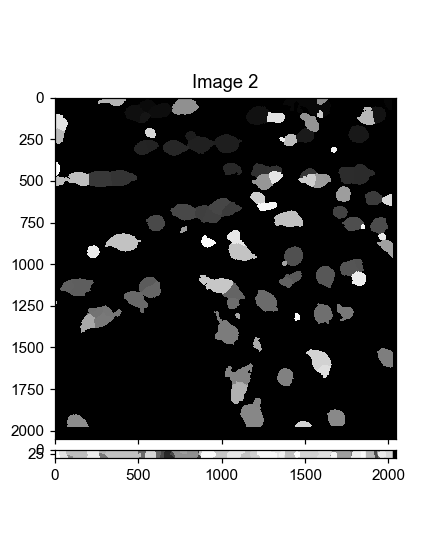

In [21]:
%matplotlib notebook
visual_tools.imshow_mark_3d_v2([_dna_dapi, dna_mask])

<IPython.core.display.Javascript object>


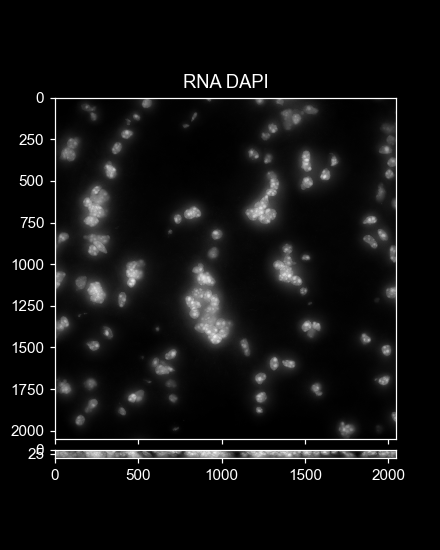

In [21]:
%matplotlib notebook
plt.style.use('dark_background')
_vis = ia.visual_tools.imshow_mark_3d_v2([_dna_dapi, _rna_dapi, _rot_dna_dapi], 
                                         #min_max_default=[10000,50000], 
                                         image_names=['DNA DAPI', 'RNA DAPI', 'Rotated DNA DAPI'])
#_vis.f.savefig(os.path.join(segmentation_folder, 'test_dna_dapi.png'), transparent=True)

## 1.5 batch run translation

In [22]:
%%time
from ImageAnalysis3.segmentation_tools.cell import _batch_align_segmentation
# Multiprocessing
print(f"- Start multiprocessing segmentation alignment", end=' ')
_start_time = time.time()
with mp.Pool(12) as _seg_pool: # 6 cores recommended because of RAM comsumption
    # start multiprocessing
    _seg_pool.starmap(_batch_align_segmentation, _seg_align_args, chunksize=1)
    # close multiprocessing
    _seg_pool.close()
    _seg_pool.join()
    _seg_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

- Start multiprocessing segmentation alignment finish in 2477.306s. 
Wall time: 41min 17s


### 1.5.2 non-parallel version

In [73]:
reload(ia.segmentation_tools.cell)

<module 'ImageAnalysis3.segmentation_tools.cell' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\segmentation_tools\\cell.py'>

In [ ]:
%matplotlib inline
reload(ia.segmentation_tools.cell)
reload(correction_tools.alignment)
from ImageAnalysis3.segmentation_tools.cell import _batch_align_segmentation
for _args in _seg_align_args:
    _outputs = _batch_align_segmentation(*_args)